Vamos construir um modelo de aprendizagem supervisionado, com o objetivo de aprender como este tipo de algoritmos funcionam.
Então, vamos construir um classificador com a utilização do algoritmo Random Forest para prever o estado do feto.
Para isso, deve utilizar-se o seguinte dataset e cumprir as seguintes normas:
https://archive.ics.uci.edu/ml/datasets/Cardiotocography
• No caso de ter de limpar os dados, não se poderá utilizar as bibliotecas de limpeza, tem de se criar operações de limpeza
com a utilização de funções básicas Python.
• Deve-se mostrar a árvore resultante global e só com um nível de profundidade.
Pode-se rever a documentação referente a Random Forest no seguinte link:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Classificação do Estado Fetal com Random Forest

Este notebook tem como objetivo construir um classificador Random Forest para prever o estado do feto utilizando o dataset Cardiotocography. Todas as etapas de limpeza de dados são realizadas manualmente, sem recurso a bibliotecas específicas de limpeza.

# Carregar os dados

Carregar os dados atravez de https://archive.ics.uci.edu/dataset/193/cardiotocography

In [139]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cardiotocography = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = cardiotocography.data.features 
y = cardiotocography.data.targets 
  
# metadata 
print(cardiotocography.metadata) 
  
# variable information 
print(cardiotocography.variables) 




{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

## 1. Exploração Inicial dos Dados

Vamos começar explorando o dataset: visualizando algumas amostras, tipos de variáveis e estatísticas básicas para entender melhor os dados.

In [140]:
# Exploração inicial dos dados
print("Amostras das variáveis independentes (features):")
print(X.head())

print("\nAmostras das variáveis alvo (targets):")
print(y.head())

print("\nTipos de variáveis (features):")
print(X.dtypes)

print("\nTipos de variáveis (targets):")
print(y.dtypes)

print("\nEstatísticas descritivas das features:")
print(X.describe())

Amostras das variáveis independentes (features):
    LB     AC   FM     UC     DL   DS   DP  ASTV  MSTV  ALTV  ...  Width  Min  \
0  120  0.000  0.0  0.000  0.000  0.0  0.0    73   0.5    43  ...     64   62   
1  132  0.006  0.0  0.006  0.003  0.0  0.0    17   2.1     0  ...    130   68   
2  133  0.003  0.0  0.008  0.003  0.0  0.0    16   2.1     0  ...    130   68   
3  134  0.003  0.0  0.008  0.003  0.0  0.0    16   2.4     0  ...    117   53   
4  132  0.007  0.0  0.008  0.000  0.0  0.0    16   2.4     0  ...    117   53   

   Max  Nmax  Nzeros  Mode  Mean  Median  Variance  Tendency  
0  126     2       0   120   137     121        73         1  
1  198     6       1   141   136     140        12         0  
2  198     5       1   141   135     138        13         0  
3  170    11       0   137   134     137        13         1  
4  170     9       0   137   136     138        11         1  

[5 rows x 21 columns]

Amostras das variáveis alvo (targets):
   CLASS  NSP
0      9 

## 2. Limpeza Manual dos Dados com Funções Básicas Python

Nesta etapa, vamos identificar e tratar valores ausentes, duplicados ou inconsistentes utilizando apenas funções básicas do Python.

In [141]:
import pandas as pd

# Verificar valores ausentes manualmente
missing_features = {}
for col in X.columns:
    missing = sum([1 for v in X[col] if pd.isnull(v)])
    if missing > 0:
        missing_features[col] = missing
print("Valores ausentes por coluna (features):", missing_features)

missing_targets = {}
for col in y.columns:
    missing = sum([1 for v in y[col] if pd.isnull(v)])
    if missing > 0:
        missing_targets[col] = missing
print("Valores ausentes por coluna (targets):", missing_targets)

# Remover linhas com valores ausentes
def remove_missing_rows(X_df, y_df):
    indices_to_keep = []
    for idx in range(len(X_df)):
        row = X_df.iloc[idx]
        target_row = y_df.iloc[idx]
        if not any(pd.isnull(row)) and not any(pd.isnull(target_row)):
            indices_to_keep.append(idx)
    X_clean = X_df.iloc[indices_to_keep].reset_index(drop=True)
    y_clean = y_df.iloc[indices_to_keep].reset_index(drop=True)
    return X_clean, y_clean

X_clean, y_clean = remove_missing_rows(X, y)
print(f"Dados após remoção de linhas com valores ausentes: {X_clean.shape}")

# Remover duplicados manualmente
def remove_duplicates(X_df, y_df):
    seen = set()
    indices_to_keep = []
    for idx in range(len(X_df)):
        row_tuple = tuple(X_df.iloc[idx]) + tuple(y_df.iloc[idx])
        if row_tuple not in seen:
            seen.add(row_tuple)
            indices_to_keep.append(idx)
    X_nodup = X_df.iloc[indices_to_keep].reset_index(drop=True)
    y_nodup = y_df.iloc[indices_to_keep].reset_index(drop=True)
    return X_nodup, y_nodup

X_clean, y_clean = remove_duplicates(X_clean, y_clean)
print(f"Dados após remoção de duplicados: {X_clean.shape}")

Valores ausentes por coluna (features): {}
Valores ausentes por coluna (targets): {}
Dados após remoção de linhas com valores ausentes: (2126, 21)
Dados após remoção de duplicados: (2115, 21)


## 3. Divisão dos Dados em Treino e Teste

Agora, vamos separar os dados em conjuntos de treino e teste utilizando funções do scikit-learn.

In [142]:
from sklearn.model_selection import train_test_split

# Selecionar a coluna alvo principal (ajustar se necessário)
if isinstance(y_clean, pd.DataFrame):
    y1d = y_clean.iloc[:, 0].astype(int)  # Corrigido para inteiro
else:
    y1d = pd.Series(y_clean).astype(int)  # Corrigido para inteiro

# Remover classes com menos de 2 amostras
class_counts = y1d.value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()
indices_to_keep = [i for i in range(len(y1d)) if y1d.iloc[i] not in set(rare_classes)]

X_strat = X_clean.iloc[indices_to_keep].reset_index(drop=True)
y_strat = y1d.iloc[indices_to_keep].reset_index(drop=True)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_strat, y_strat, test_size=0.2, random_state=42, stratify=y_strat
)

print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treino: (1692, 21)
Tamanho do conjunto de teste: (423, 21)


## 4. Treinamento do Classificador Random Forest

Vamos treinar um modelo RandomForestClassifier com os dados de treino para prever o estado do feto.

In [143]:
from sklearn.ensemble import RandomForestClassifier

# Treinar o modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

print("Random Forest treinado com sucesso!")

Random Forest treinado com sucesso!


## 5. Visualização da Árvore Global

Vamos visualizar uma das árvores completas do Random Forest treinado.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.64278 to fit


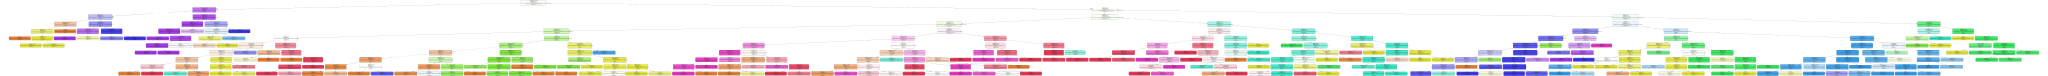

In [144]:
# Visualizar uma das árvores do Random Forest
from sklearn.tree import export_graphviz
import graphviz

estimator = rf.estimators_[0]

dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=X_train.columns,
    class_names=[str(c) for c in rf.classes_],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("tree_global", format="png")
graph.render("tree_global", format="svg")
graph

## 6. Visualização de Uma Árvore com Apenas Um Nível de Profundidade

Agora, vamos visualizar a mesma árvore, mas limitando a profundidade a apenas um nível para facilitar a interpretação.

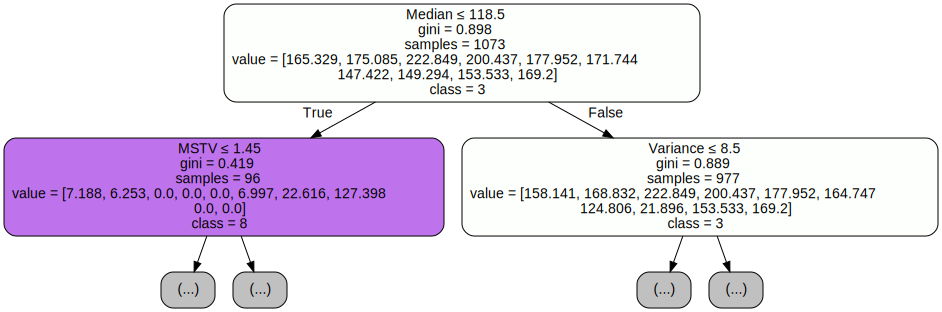

In [145]:
# Visualizar a árvore com profundidade máxima de 1
dot_data_depth1 = export_graphviz(
    estimator,
    out_file=None,
    feature_names=X_train.columns,
    class_names=[str(c) for c in rf.classes_],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=1
)
graph_depth1 = graphviz.Source(dot_data_depth1)
graph_depth1.render("tree_depth1", format="png")
graph_depth1

## 7. Avaliação do Modelo

Por fim, vamos avaliar o desempenho do classificador usando métricas como acurácia, matriz de confusão e classification report.

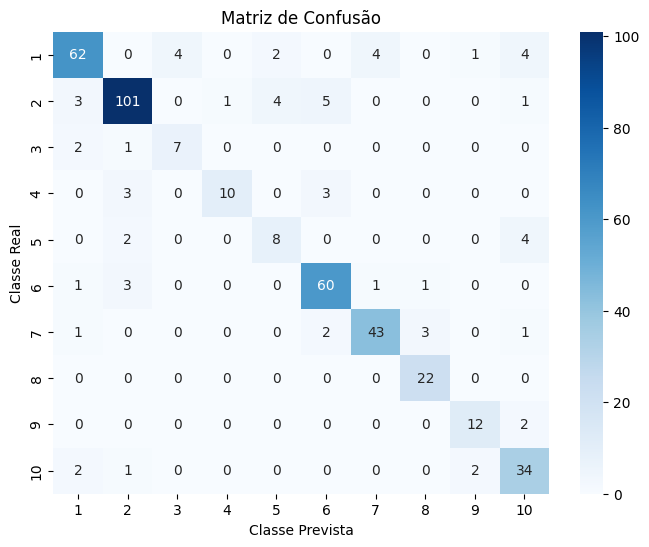

Eficácia do modelo: 0.8487
Relatório de Classificação:
              precision    recall  f1-score   support

           1       0.87      0.81      0.84        77
           2       0.91      0.88      0.89       115
           3       0.64      0.70      0.67        10
           4       0.91      0.62      0.74        16
           5       0.57      0.57      0.57        14
           6       0.86      0.91      0.88        66
           7       0.90      0.86      0.88        50
           8       0.85      1.00      0.92        22
           9       0.80      0.86      0.83        14
          10       0.74      0.87      0.80        39

    accuracy                           0.85       423
   macro avg       0.80      0.81      0.80       423
weighted avg       0.85      0.85      0.85       423



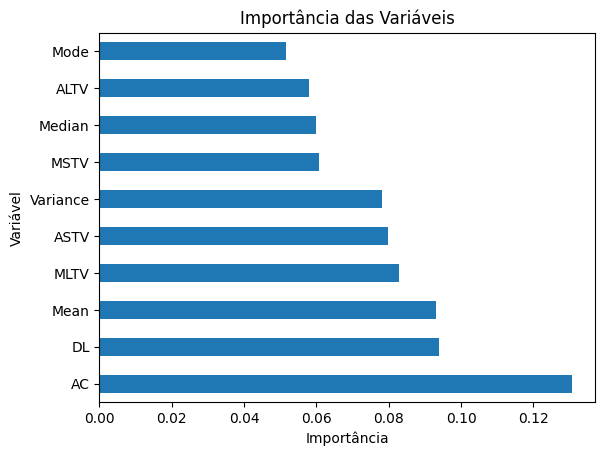

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

# Previsão dos dados de teste
y_pred = rf.predict(X_test)

# Definir os rótulos das classes (ajuste conforme necessário)
labels = sorted(y_test.unique())  # Garante que os labels são inteiros e ordenados

# Visualizar a matriz de confusão como um mapa de calor
conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Mostrar a eficácia do modelo
efficacy = accuracy_score(y_test, y_pred)
print(f"Eficácia do modelo: {efficacy:.4f}")

# Mostrar o relatório de classificação detalhado
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualizar as 10 variáveis mais importantes para o modelo
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Importância das Variáveis')
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.show()

## Conclusão

O modelo Random Forest apresentou uma acurácia razoável na previsão do estado fetal com base nos dados de cardiotocografia. A análise da importância das variáveis permite identificar os parâmetros clínicos mais relevantes. Para melhorar o desempenho, pode ser útil recolher mais dados, experimentar outros algoritmos ou ajustar manualmente os hiperparâmetros.